In [31]:
# import data 
import numpy as np
import pandas as df
np_folder = 'PRSA_preprocess/PRSA_Wanshouxigong_numpy' #run this FR
np_split = np_folder.split('/')
np_file = np_split[1]
splitter = np_file.split('_')
display_name = splitter[0] + '_' + splitter[1]
hi = np.load('PRSA_preprocess/' + np_file + '.npy', allow_pickle=True)

dataframeee = df.DataFrame(hi)
dataframeee.columns = ['No', 'year', 'month','day', 'hour','PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station']
dataframeee.to_csv(display_name + '.csv', index=False) # comma separated

In [32]:
import pandas as pd
from datetime import datetime
import io

# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
 
# dataset = pd.read_csv(io.BytesIO(uploaded[hello]),  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset = pd.read_csv(display_name + '.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
dataset.drop('PM10', axis=1, inplace=True)
dataset.drop('SO2', axis=1, inplace=True)
dataset.drop('CO', axis=1, inplace=True)
dataset.drop('NO2', axis=1, inplace=True)
dataset.drop('O3', axis=1, inplace=True)
# for now drop station
dataset.drop('station', axis=1, inplace=True)
dataset.index.name = 'date'

print(dataset)

                     PM2.5  TEMP    PRES  DEWP  RAIN     wd  WSPM
date                                                             
2013-03-01 00:00:00    9.0   0.3  1021.9 -19.0   0.0  292.5   2.0
2013-03-01 01:00:00   11.0  -0.1  1022.4 -19.3   0.0  292.5   4.4
2013-03-01 02:00:00    8.0  -0.6  1022.6 -19.7   0.0  292.5   4.7
2013-03-01 03:00:00    8.0  -0.7  1023.5 -20.9   0.0  315.0   2.6
2013-03-01 04:00:00    8.0  -0.9  1024.1 -21.7   0.0  292.5   2.5
...                    ...   ...     ...   ...   ...    ...   ...
2017-02-28 19:00:00   11.0  12.5  1013.5 -16.2   0.0  315.0   2.4
2017-02-28 20:00:00   13.0  11.6  1013.6 -15.1   0.0  292.5   0.9
2017-02-28 21:00:00   14.0  10.8  1014.2 -13.3   0.0  315.0   1.1
2017-02-28 22:00:00   12.0  10.5  1014.4 -12.9   0.0  337.5   1.2
2017-02-28 23:00:00   13.0   8.6  1014.1 -15.9   0.0   22.5   1.3

[35064 rows x 7 columns]


In [33]:
# mark all NA values with 0
dataset['PM2.5'].fillna(0, inplace=True)
# drop the first 24 hours
#dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))

# save to file
dataset.to_csv(display_name + '_pollution.csv')

                     PM2.5  TEMP    PRES  DEWP  RAIN     wd  WSPM
date                                                             
2013-03-01 00:00:00    9.0   0.3  1021.9 -19.0   0.0  292.5   2.0
2013-03-01 01:00:00   11.0  -0.1  1022.4 -19.3   0.0  292.5   4.4
2013-03-01 02:00:00    8.0  -0.6  1022.6 -19.7   0.0  292.5   4.7
2013-03-01 03:00:00    8.0  -0.7  1023.5 -20.9   0.0  315.0   2.6
2013-03-01 04:00:00    8.0  -0.9  1024.1 -21.7   0.0  292.5   2.5


In [34]:
from matplotlib import pyplot
# load dataset
dataset = pd.read_csv(display_name + '_pollution.csv', header=0, index_col=0)

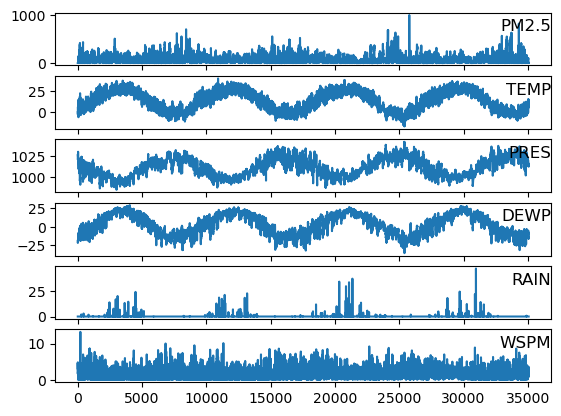

In [35]:
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3,  4, 6]
i = 1
# plot each column
pyplot.figure()
for group in groups:
  pyplot.subplot(len(groups), 1, i)
  #print("i: " + str(i) + ", " + str(values[:,group]))
  pyplot.plot(values[:, group])
  pyplot.title(dataset.columns[group], y=0.5, loc='right')
  i += 1
pyplot.show()

In [36]:
# Multivariate LSTM Forecast Model
# Problem: predicting the pollution at the current hour (t) given the pollution measurement and weather conditions at the prior time step

# The wind direction feature is label encoded (integer encoded). This could further be one-hot encoded in the future if you are interested in exploring it
# Next, all features are normalized, then the dataset is transformed into a supervised learning problem. The weather variables for the hour to be predicted (t) are then removed.
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
 
	# input sequence (t-n, ... t-1)
	# n_in is the number of hours as input
	for i in range(n_in, 0, -1):

		# grab row of data and appent to col
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

	# forecast sequence (t, t+1, ... t+n)
	# n_out is the number of PM we want to predict
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	
		# drop columns we don't want to predict
		# drop next hour stats for meteorological keep PM data
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# drop columns we don't want to predict
# drop next hour stats for meteorological keep PM data
def resize(df):
  drop_list = []
  for i in range((input*7), (input+output)*7, 1):
      if (i%7 != 0):
        drop_list.append(i)
  print(drop_list)
  df.drop(reframed.columns[drop_list], axis=1, inplace=True)

In [37]:
# Preprocessing
# integer encode direction

encoder = LabelEncoder()
values[:,5] = encoder.fit_transform(values[:,5])

#print(values[:,5])
# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled.shape)

(35064, 7)


In [38]:
# frame as supervised learning
input = 48
output = 6

# input how many hours to use as input
# output how many hours predict in future (only want PM)
reframed = series_to_supervised(scaled, input, output)
resize(reframed)
reframed.head()

[337, 338, 339, 340, 341, 342, 344, 345, 346, 347, 348, 349, 351, 352, 353, 354, 355, 356, 358, 359, 360, 361, 362, 363, 365, 366, 367, 368, 369, 370, 372, 373, 374, 375, 376, 377]


,var1(t-48),var2(t-48),var3(t-48),var4(t-48),var5(t-48),var6(t-48),var7(t-48),var1(t-47),var2(t-47),var3(t-47),...,var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5)
48,0.006024,0.297909,0.646748,0.255486,0.0,0.957447,0.151515,0.008032,0.290941,0.655537,...,0.363636,0.0,0.000000,0.007576,0.098394,0.074297,0.094378,0.104418,0.104418,0.101406
49,0.008032,0.290941,0.655537,0.250784,0.0,0.957447,0.333333,0.005020,0.282230,0.659050,...,0.330721,0.0,0.106383,0.098485,0.074297,0.094378,0.104418,0.104418,0.101406,0.084337
50,0.005020,0.282230,0.659050,0.244514,0.0,0.957447,0.356061,0.005020,0.280488,0.674868,...,0.326019,0.0,0.021277,0.106061,0.094378,0.104418,0.104418,0.101406,0.084337,0.083333
51,0.005020,0.280488,0.674868,0.225705,0.0,0.989362,0.196970,0.005020,0.277003,0.685411,...,0.343260,0.0,0.882979,0.045455,0.104418,0.104418,0.101406,0.084337,0.083333,0.081325
52,0.005020,0.277003,0.685411,0.213166,0.0,0.957447,0.189394,0.007028,0.264808,0.695955,...,0.369906,0.0,0.723404,0.030303,0.104418,0.101406,0.084337,0.083333,0.081325,0.085341


In [39]:
# Define and Fit Model
# split into train and test sets
values = reframed.values
features = 7
n_train_hours = 365 * 24 * 3
# train 75 % / test 25 %
train = values[:n_train_hours, :]

# rest is test data
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :input*features], train[:, input*features:]
test_X, test_y = test[:, :input*features], test[:, input*features:]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# around 9k hours of training, 26k hours of testing

(26280, 1, 336) (26280, 6) (8731, 1, 336) (8731, 6)


In [40]:
from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [41]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(output)(x)
    return keras.Model(inputs, outputs)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1, 336)]     0           []                               
                                                                                                  
 layer_normalization_16 (LayerN  (None, 1, 336)      672         ['input_3[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_8 (MultiH  (None, 1, 336)      1379664     ['layer_normalization_16[0][0]', 
 eadAttention)                                                    'layer_normalization_16[0][0]'] 
                                                                                            

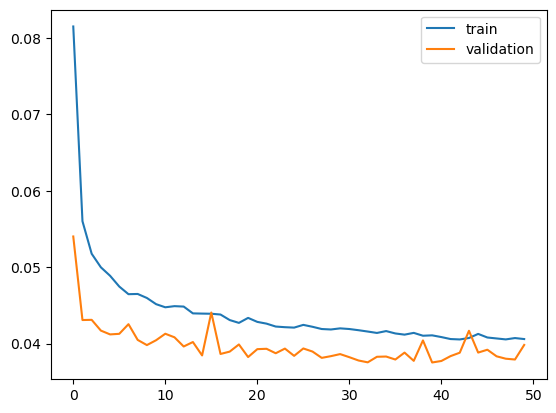

In [42]:
from keras import backend as K

input_shape = train_X.shape[1:]
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 


model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss=root_mean_squared_error,
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, \
    restore_best_weights=True)]

history = model.fit(
    train_X,
    train_y,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
)

print("rmse on test")
model.evaluate(test_X, test_y, verbose=1)

# plot history for train/validation
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

In [43]:
from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error

# Get prediction there can be multiple 
yhat = model.predict(test_X)
print(yhat.shape)

# rmse list
rmse_list = []

# this is just for inverse transform
test_X = test_X.reshape((test_X.shape[0], input*features))

to_save = np.zeros(shape=(yhat.shape[0], 1))


# calc rmse for every prediction
for i in range(yhat.shape[1]): # 24
  # invert scaling for forecast
  inv_yhat = concatenate((yhat[:, i:i+1], test_X[:, -(features-1):]), axis=1)
  inv_yhat = scaler.inverse_transform(inv_yhat)
  inv_yhat = inv_yhat[:,0] # save in a list append them all together
  
  inv_yhat_reshape = np.reshape(inv_yhat, (len(inv_yhat), 1))
  to_save = np.hstack((to_save, inv_yhat_reshape))

    # now save predictions

    # wanshou (inv_yhat=pred)    

    # y x 24 x 12 average along rows
    # 0
    # 1
    # 2
    # 3
    # 4

    # 5
    # 6
    # 7


  # invert scaling for actual
  inv_y = concatenate((test_y[:, i:i+1], test_X[:, -(features-1):]), axis=1)
  inv_y = scaler.inverse_transform(inv_y)
  inv_y = inv_y[:,0]

  rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
  rmse_list.append(rmse)

# calculate RMSE
avg_rmse = sum(rmse_list) / len(rmse_list)
print('Test RMSE: %.3f' % avg_rmse)

# 8713 x 24
to_save = to_save[:, 1:]
print(to_save.shape)
np.save('Transformer_preds_np_48_6/' + display_name + "_np.npy", to_save)

273/273 [==============================] - 2s 7ms/step
(8731, 6)
Test RMSE: 42.817
(8731, 6)


In [44]:
to_save.shape

(8731, 6)

In [45]:
# model.save('Transformer_models_48_24/' + display_name)